<b>Import needed libraries</b>

In [11]:
import os
import urllib2
import pyart
import awot
#import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<b>Create a class for accessing and plotting latest radar image via a web repository</b>

In [15]:
class Get88D(object):
    """
    A class mentod to retrieve and plot NEXRAD data.
    
    The metar retrieval is a modification of code found at:
    https://github.com/akrherz/iem/blob/master/scripts/asos/iem_scraper_example.py
    
    It is dependent upon the Iowa State Mesonet database.
    """
    def __init__(self, radarID):
        '''Initialize the class'''

        # Set date formats to be used with datetime
        self.d_fmt = "%Y-%m-%d %H:%M"
        self.dout_fmt = "%Y-%m-%d_%H:%M"
        
        # Use passed arguments
        self.radarID = radarID

    def get_data(self):
        '''Function to return metar data and create output text file'''
        # Query the radarID directory to get file list
        SERVICE = "http://nomads.ncep.noaa.gov/pub/data/nccf/radar/nexrad_level2"
        nexurl = '%s/%s/'%(SERVICE, self.radarID)
        response = urllib2.urlopen("%s%s"%(nexurl, "dir.list"))
        self.list88D = response.read().split("\n")
        
        # At this point you have a list of data files, BUT there are 2 columns
        # col 1 = file size, col2 = filename
        
        # Now grab the latest data file and save it locally to open
        data = urllib2.urlopen("%s%s"%(nexurl,self.list88D[-2].split(" ")[1]))
        with open("latest88D.bz", "wb") as code:
            code.write(data.read())

    def plot_nexrad(self, vmin=None, vmax=None, xlims=None, ylims=None):
        '''Create a plot'''
        # Create a PyArt radar instance
        fig, ax = plt.subplots()
        #ax = plt.axes()
        r=pyart.io.read_nexrad_archive("latest88D.bz")
        d=pyart.graph.RadarDisplay(r)
        d.plot('reflectivity',0, vmin=vmin, vmax=vmax, cmap="pyart_Carbone42")
        if xlims is None:
            xlims = (-250., 250)
        if ylims is None:
            ylims = (-250., 250)
        d.set_limits(xlims, ylims)
        
    def plot_cfad(self):
        rAWOT = awot.io.read_ground_radar("latest88D.bz", map_to_awot=True)
        rAWOT_util = awot.graph.RadarUtilityPlot(rAWOT)
        
        figC, (axC0, axC1) = plt.subplots(1, 2, sharey=True)
        rAWOT_util.plot_bivariate_frequency('reflectivity', 'height',# start_time=start_time, end_time=end_time,
                                    xbinsminmax=(-10., 60.), ybinsminmax=(0., 10000.), nbinsx=71, nbinsy=100,
                                    mask_below=0.00001, plot_colorbar=True, plot_percent=True, 
                                    xlab= "Reflectivity (dBZ)", ylab="Altitude (m)", xpad=10,
                                    title="Frequency Distribution", titleFontSize=12, ax=axC0, fig=figC)
        
        rAWOT_util.plot_cfad('reflectivity', 
                    xbinsminmax=(-10., 60.), nbinsx=71, plot_percent=True, plot_colorbar=True,
                    mask_below=.01, ax=axC1)
 
    def remove_bz(self):
        os.remove("latest88D.bz")

<b>Initialize the Radar class and pull in most recent file.</b>

In [16]:
radarID = "KBHX"#KCYS"
Radar = Get88D(radarID)
Radar.get_data()

<b>Now lets make a current PPI plot!</b>

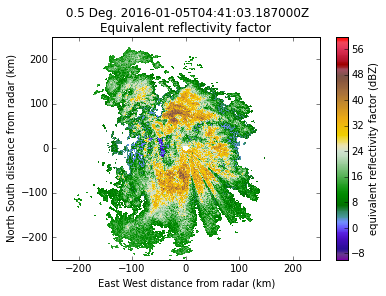

In [17]:
Radar.plot_nexrad(vmin=-10, vmax=60.)

<b>And a CFAD plot</b>

In [18]:
Radar.plot_cfad()

TypeError: unsupported operand type(s) for -: 'float' and 'datetime.datetime'

<b>Clean up the directory by removing the file.</b>

In [ ]:
Radar.remove_bz()